# First look at H2C Commissioning Data
This notebook will be run daily to give us a glance at the early commissioning data as it arrives at NRAO. The goal is to run some of our analysis steps and provide useful plots.

In [44]:
%matplotlib notebook
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import matplotlib.patches as mpatches
import numpy as np
import hera_qm as hqm
import hera_cal as hc
from pyuvdata import UVCal, UVData, UVFITS
import os
import sys
import glob
import copy
import re
import uvtools as uvt
from astropy.time import Time
from collections import OrderedDict

## Set up Env variables and get files

In [2]:
# get data location
# Uncomment this line and delete the next when ready for the real deal
# data_path = os.environ['DATA_PATH']
data_path = '/users/abeardsl/lustre/2458042/'  # Subset of H1C IDR1 raw data files

# get xx and yy files
xxfiles = sorted(glob.glob("{0}/zen.*.*.xx.HH.uvh5".format(data_path)))
yyfiles = sorted(glob.glob("{0}/zen.*.*.yy.HH.uvh5".format(data_path)))
Nfiles = len(xxfiles)

xxfile_bases = map(os.path.basename, xxfiles)
yyfile_bases = map(os.path.basename, yyfiles)

xxfile_times = np.array(map(lambda x: '.'.join(os.path.basename(x).split('.')[1:3]), xxfiles), np.float)
yyfile_times = np.array(map(lambda y: '.'.join(os.path.basename(y).split('.')[1:3]), yyfiles), np.float)

# choose one for single-file plots
file_index = np.min([len(xxfiles)-1, 20])
xxfile = xxfiles[file_index]
yyfile = yyfiles[file_index]
xxfile_base = xxfile_bases[file_index]
yyfile_base = yyfile_bases[file_index]
file_jd = xxfile_times[file_index]

In [3]:
# Load data
uvd_xx = UVData()
uvd_xx.read(xxfile)
uvd_xx.ants = np.unique(np.concatenate([uvd_xx.ant_1_array, uvd_xx.ant_2_array]))
uvd_yy = UVData()
uvd_yy.read(yyfile)
uvd_yy.ants = np.unique(np.concatenate([uvd_yy.ant_1_array, uvd_yy.ant_2_array]))

# Get metadata
freqs = uvd_xx.freq_array.squeeze() / 1e6
times = uvd_xx.time_array.reshape(uvd_xx.Ntimes, uvd_xx.Nbls)[:, 0]
jd_start = np.floor(times.min())
Nfreqs = len(freqs)
Ntimes = len(times)

# get redundant info
aa = hc.utils.get_aa_from_uv(uvd_xx)
info = hc.omni.aa_to_info(aa)
red_bls = np.array(info.get_reds())
antpos, ants = uvd_xx.get_ENU_antpos(pick_data_ants=False)
ants = sorted(ants)
ants_red = sorted(np.unique(np.concatenate(red_bls)))
Nants = len(ants)
Nside = int(np.ceil(np.sqrt(Nants)))
Yside = int(np.ceil(float(Nants)/Nside))

## Plot Autos

<IPython.core.display.Javascript object>


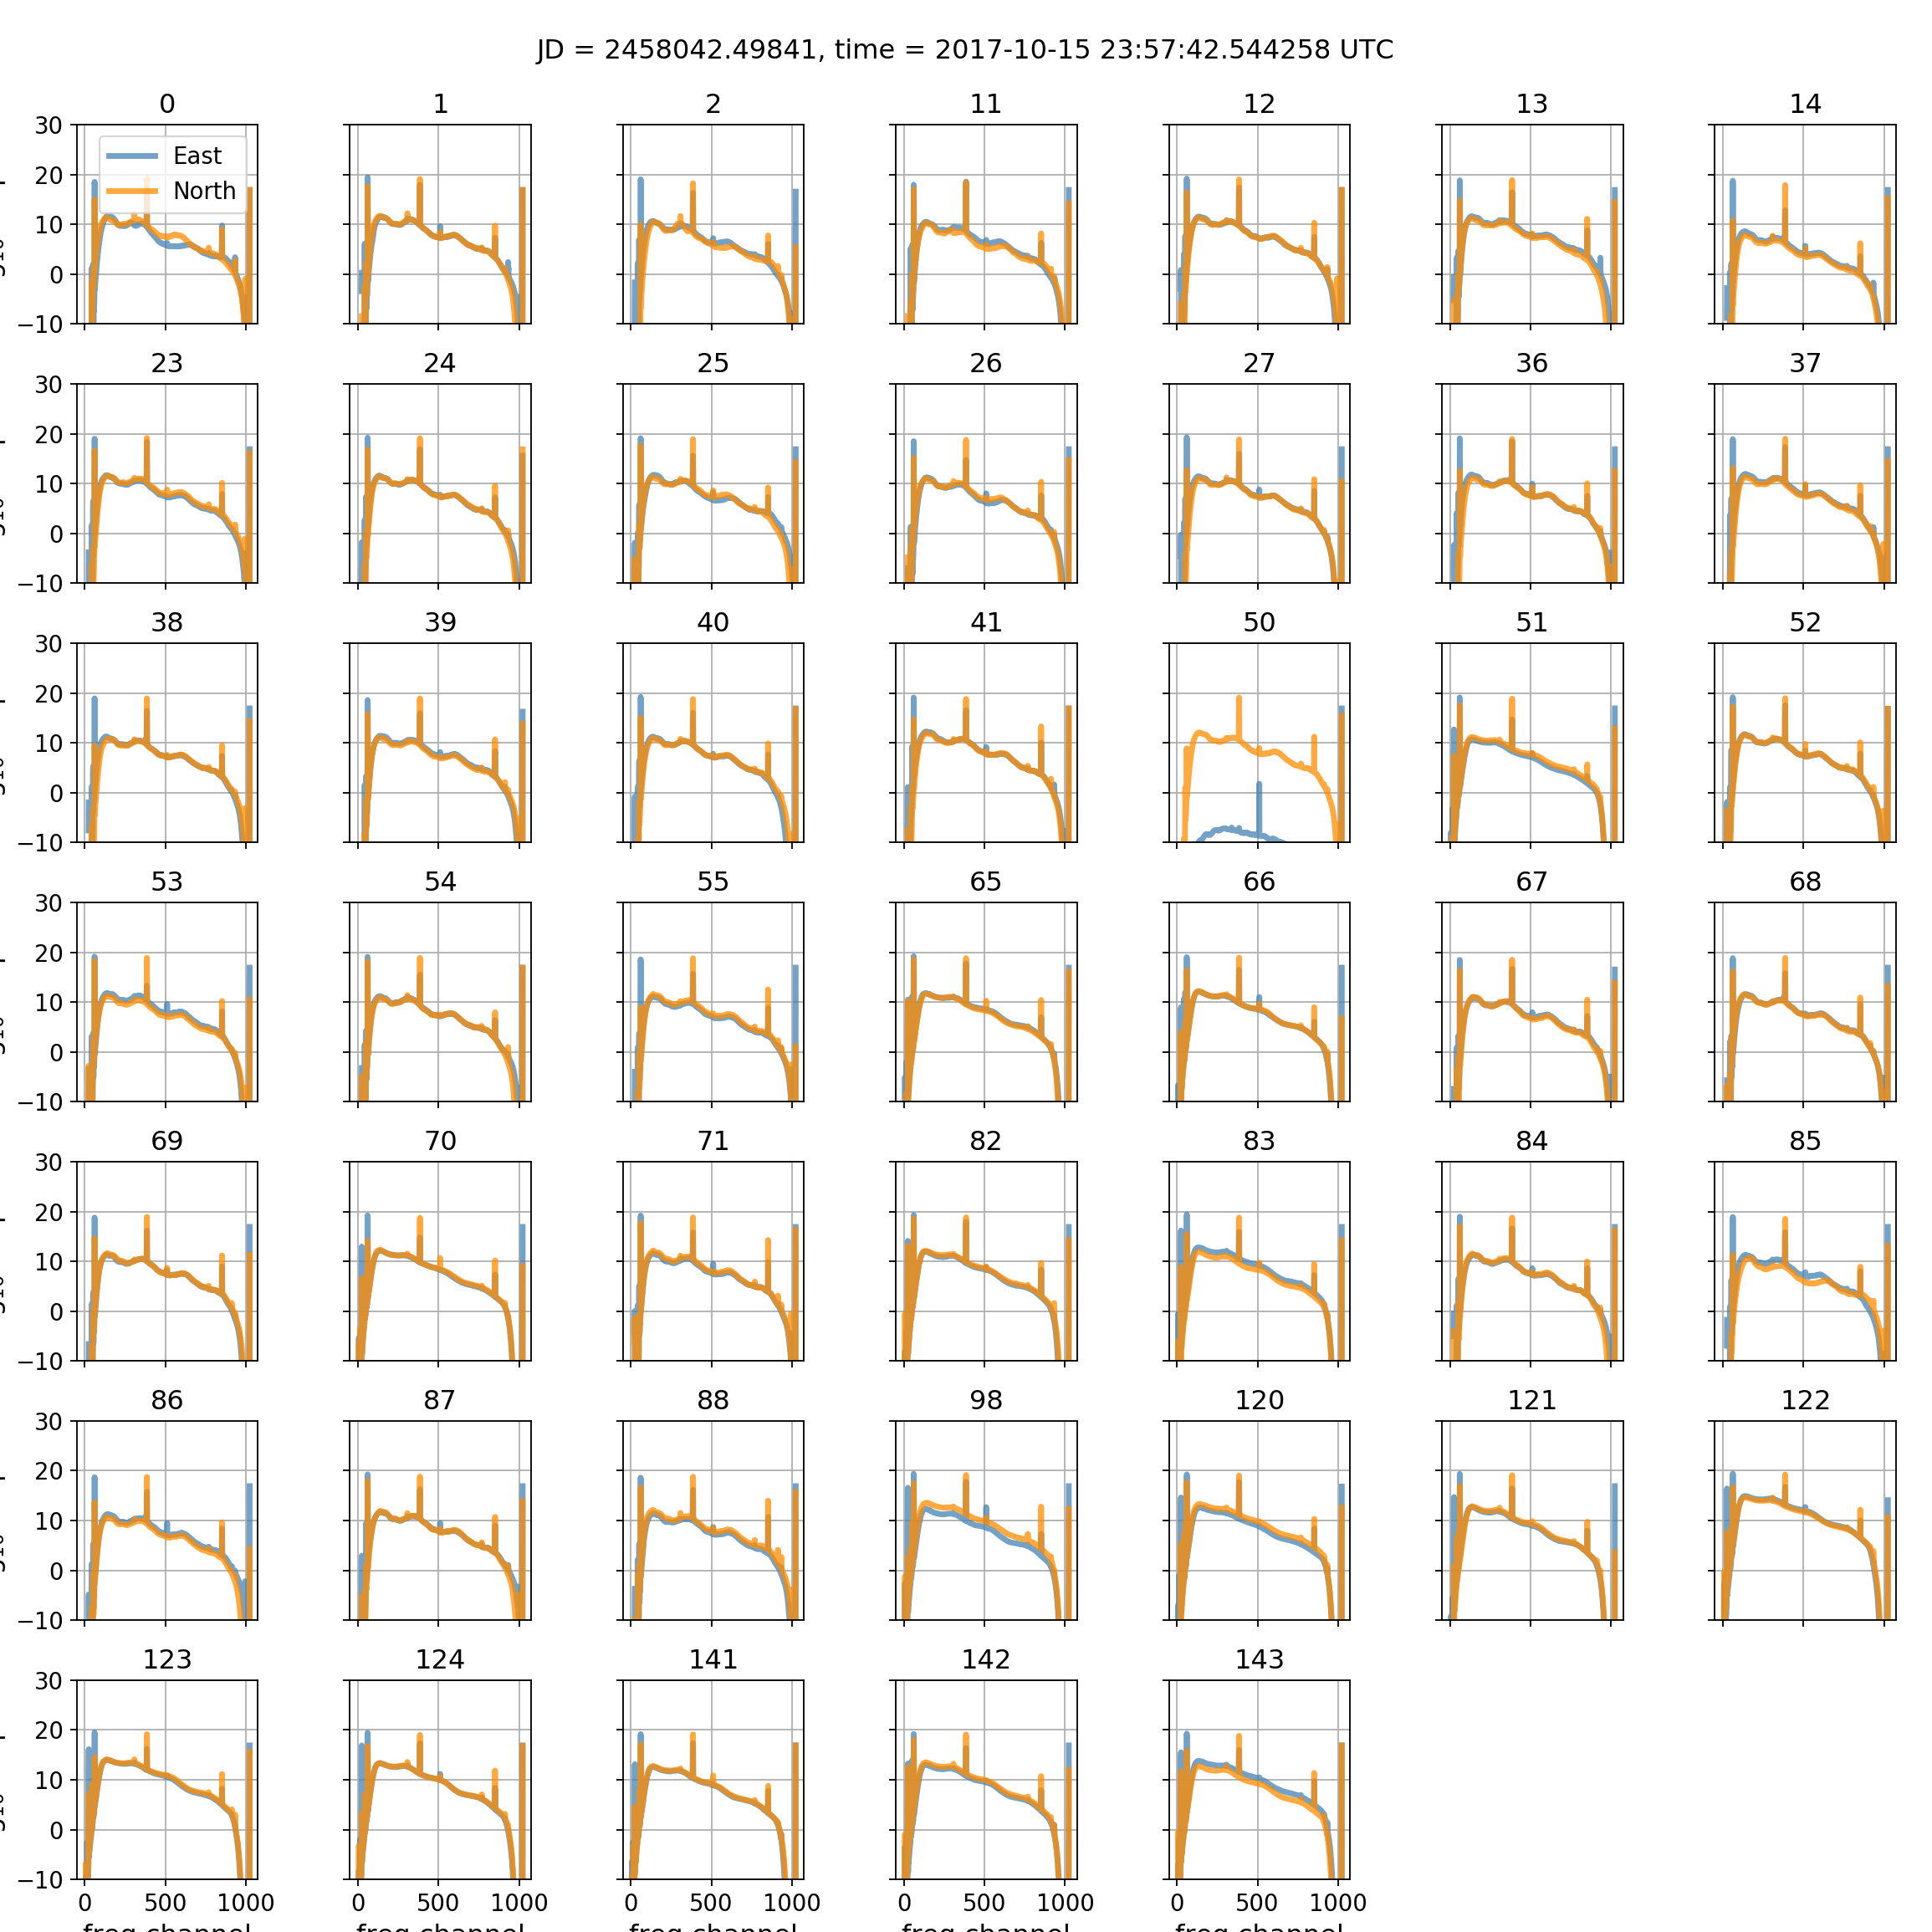

divide by zero encountered in log10
divide by zero encountered in log10


In [4]:
### plot autos
t_index = 0
jd = times[t_index]
utc = Time(jd, format='jd').datetime

xlim = (-50, Nfreqs+50)
ylim = (-10,30)

fig, axes = plt.subplots(Yside, Nside, figsize=(14,14), dpi=75)
fig.subplots_adjust(wspace=0.2, hspace=0.2)
fig.suptitle("JD = {0}, time = {1} UTC".format(jd, utc), fontsize=14)
fig.tight_layout(rect=(0, 0, 1, 0.95))

k = 0
for i in range(Yside):
    for j in range(Nside):
        ax = axes[i,j]
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)
        if k < Nants:
            px, = ax.plot(10*np.log10(np.abs(uvd_xx.get_data((ants[k], ants[k]))[t_index])),
                          color='steelblue', alpha=0.75, linewidth=3)
            py, = ax.plot(10*np.log10(np.abs(uvd_yy.get_data((ants[k], ants[k]))[t_index])),
                          color='darkorange', alpha=0.75, linewidth=3)
            ax.grid(True, which='both')
            ax.set_title(str(ants[k]), fontsize=14)
            if k == 0:
                ax.legend([px, py], ['East', 'North'], fontsize=12)
        else:
            ax.axis('off')
        if j != 0:
            ax.set_yticklabels([])
        else:
            [t.set_fontsize(12) for t in ax.get_yticklabels()]
            ax.set_ylabel(r'$10\cdot\log_{10}$ amplitude', fontsize=14)
        if i != Yside-1:
            ax.set_xticklabels([])
        else:
            [t.set_fontsize(12) for t in ax.get_xticklabels()]
            ax.set_xlabel('freq channel', fontsize=14)

        k += 1

## Plot auto amplitude at a specific frequency over entire night


In [5]:
def timeseries_data(files, nu_index=500):
    print "gather nightly data for JD = {0}".format(jd_start)
    uv = UVData()
    uv.read(files, ant_str='auto', freq_chans=[nu_index])
    amps = np.abs(uv.data_array[:, 0, 0, 0].reshape(uv.Ntimes, uv.Nants_data))
    times = np.unique(uv.time_array)
    return np.array(amps).T, np.array(times)

nu_index = 500
amps_timeseries_xx, times_xx = timeseries_data(xxfiles, nu_index=nu_index)
amps_timeseries_yy, times_yy = timeseries_data(yyfiles, nu_index=nu_index)
times_xx = times_xx % 1
times_yy = times_yy % 1

gather nightly data for JD = 2458042.0
gather nightly data for JD = 2458042.0


<IPython.core.display.Javascript object>


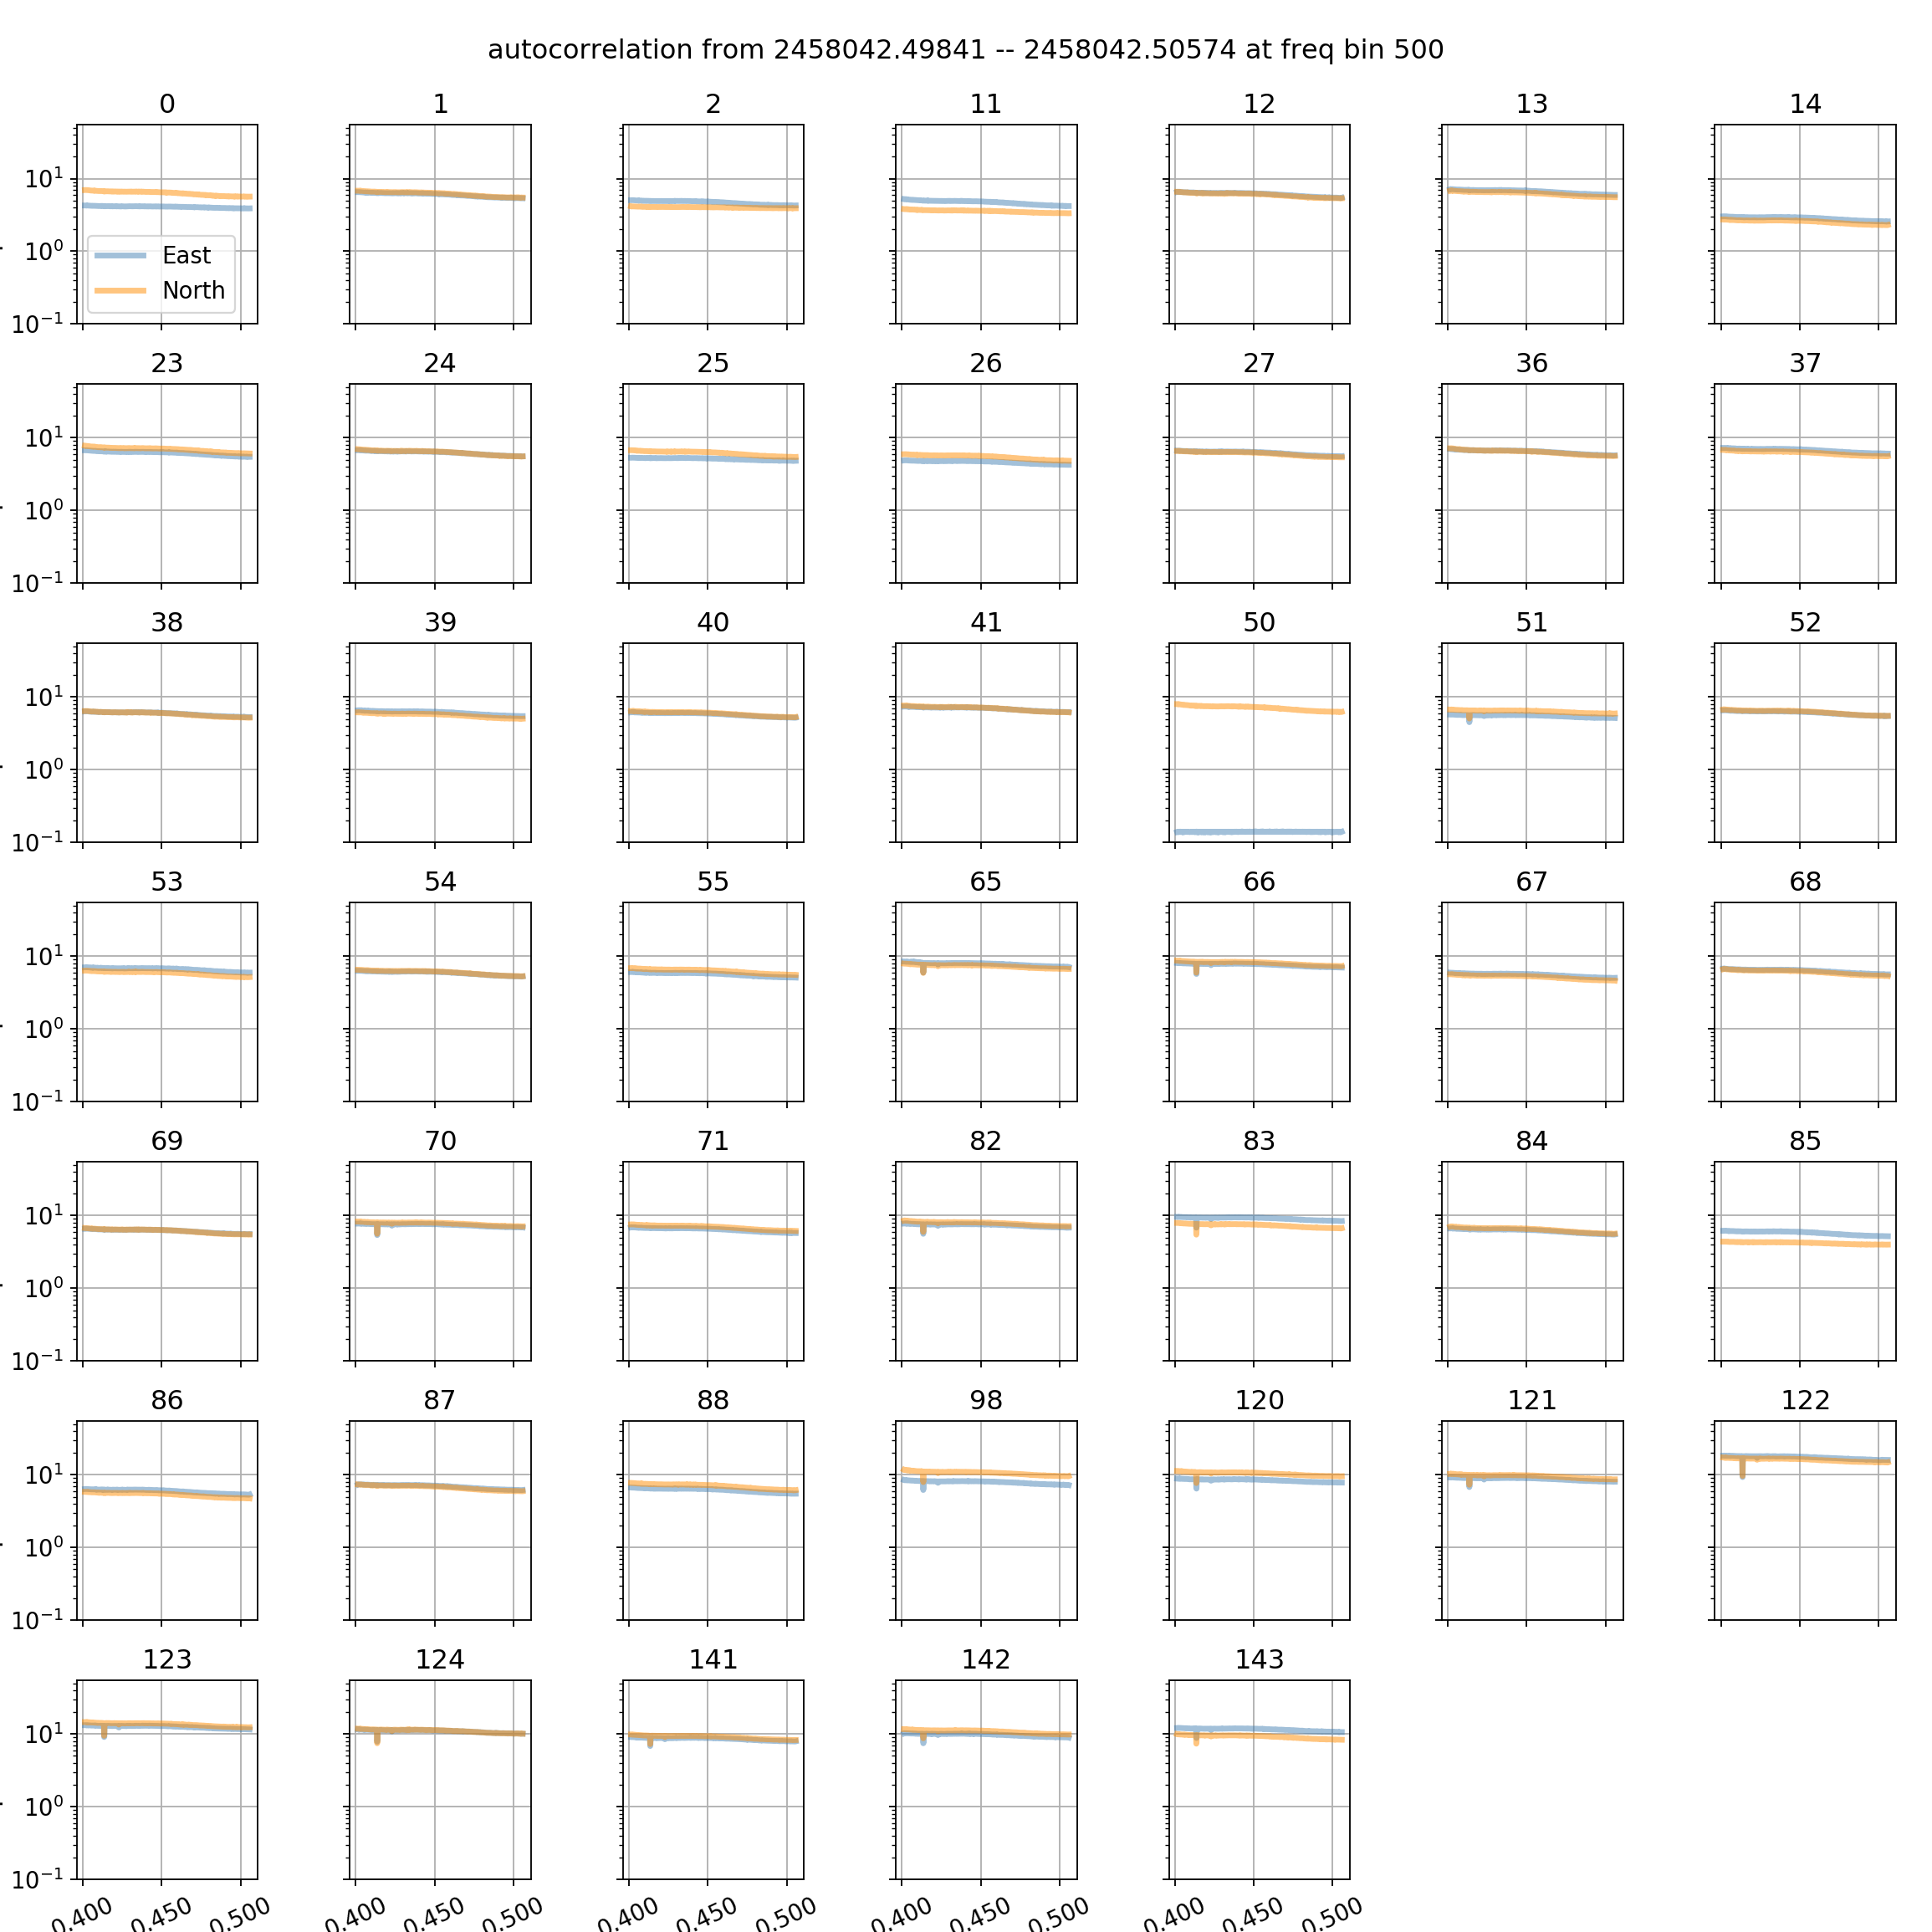

In [6]:
# plot autos
ylim = (0, np.median(np.abs(amps_timeseries_xx))*3)
ylim = (1e-1, np.abs(amps_timeseries_xx).max() * 3)

fig, axes = plt.subplots(Yside, Nside, figsize=(14,14), dpi=75)
fig.subplots_adjust(wspace=0.2, hspace=0.2)
fig.suptitle("autocorrelation from {0} -- {1} at freq bin {2}".format(times[0], times[-1], nu_index), fontsize=14)
fig.tight_layout(rect=(0, 0, 1, 0.95))

k = 0
for i in range(Yside):
    for j in range(Nside):
        ax = axes[i,j]
        ax.set_ylim(ylim)
        if k < Nants:
            ax.set_yscale('log')
            px, = ax.plot(times_xx, np.abs(amps_timeseries_xx[k]), color='steelblue', alpha=0.5, linewidth=3)
            py, = ax.plot(times_yy, np.abs(amps_timeseries_yy[k]), color='darkorange', alpha=0.5, linewidth=3)
            ax.grid(True)
            ax.set_title(str(ants[k]), fontsize=14)
            if k == 0:
                ax.legend([px, py], ['East', 'North'], fontsize=12)
        else:
            ax.axis('off')
        if j != 0:
            ax.set_yticklabels([])
        else:
            [t.set_fontsize(12) for t in ax.get_yticklabels()]
            ax.set_ylabel('amplitude', fontsize=14)
        if i != Yside-1:
            ax.set_xticklabels([])
        else:
            [t.set_fontsize(12) for t in ax.get_xticklabels()]
            [t.set_rotation(25) for t in ax.get_xticklabels()]
            ax.xaxis.set_major_formatter(FormatStrFormatter('%.3f'))
            ax.set_xlabel('decimal of JD', fontsize=14)
        k += 1

## Ant metrics

### Run

In [7]:
# Run all the metrics cause why not
# Output metrics files will look like: zen.JD.JD.HH.uvh5.ant_metrics.hdf5
hqm.ant_metrics.ant_metrics_run(xxfiles, pols=['xx', 'yy', 'yx', 'xy'], crossCut=5.0,
                                deadCut=5.0, alwaysDeadCut=10.0, metrics_path='',
                                extension='.ant_metrics.hdf5', vis_format='uvh5',
                                verbose=False, history='',
                                run_mean_vij=True, run_red_corr=True,
                                run_cross_pols=True)

Combined polarizations are not evenly spaced. This will make it impossible to write this data out to some file types.
Combined polarizations are not evenly spaced. This will make it impossible to write this data out to some file types.
Combined polarizations are not evenly spaced. This will make it impossible to write this data out to some file types.
Combined polarizations are not evenly spaced. This will make it impossible to write this data out to some file types.
Combined polarizations are not evenly spaced. This will make it impossible to write this data out to some file types.
Combined polarizations are not evenly spaced. This will make it impossible to write this data out to some file types.
Combined polarizations are not evenly spaced. This will make it impossible to write this data out to some file types.
Combined polarizations are not evenly spaced. This will make it impossible to write this data out to some file types.
Combined polarizations are not evenly spaced. This will 

### Ant metrics for a single file

In [9]:
antfile = xxfile_base.split('.')
antfile.pop(3)
antfile = os.path.join(data_path, '.'.join(antfile) + '.ant_metrics.hdf5')
ant_metrics = hqm.ant_metrics.load_antenna_metrics(antfile)

In [10]:
def plot_metric(metrics, ants=None, antpols=None, title='', ylabel='Modified z-Score', xlabel=''):
    '''Helper function for quickly plotting an individual antenna metric.'''

    if ants is None:
        ants = list(set([key[0] for key in metrics.keys()]))
    if antpols is None:
        antpols = list(set([key[1] for key in metrics.keys()]))

    for antpol in antpols:
        for i,ant in enumerate(ants):
            metric = 0
            if metrics.has_key((ant,antpol)):
                metric = metrics[(ant,antpol)]
            # skip if nan
            if np.isnan(metric): continue
            if metric is not None:
                plt.plot(i,metric,'.')
                if antpol == 'y':
                    antpol_str = 'n'
                elif antpol == 'x':
                    antpol_str = 'e'
                plt.annotate(str(ant)+antpol_str,xy=(i,metrics[(ant,antpol)]))
        plt.gca().set_prop_cycle(None)
    plt.title(title)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)

Ant Metrics for /users/abeardsl/lustre/2458042/zen.2458042.49835.HH.uvh5.ant_metrics.hdf5


<IPython.core.display.Javascript object>


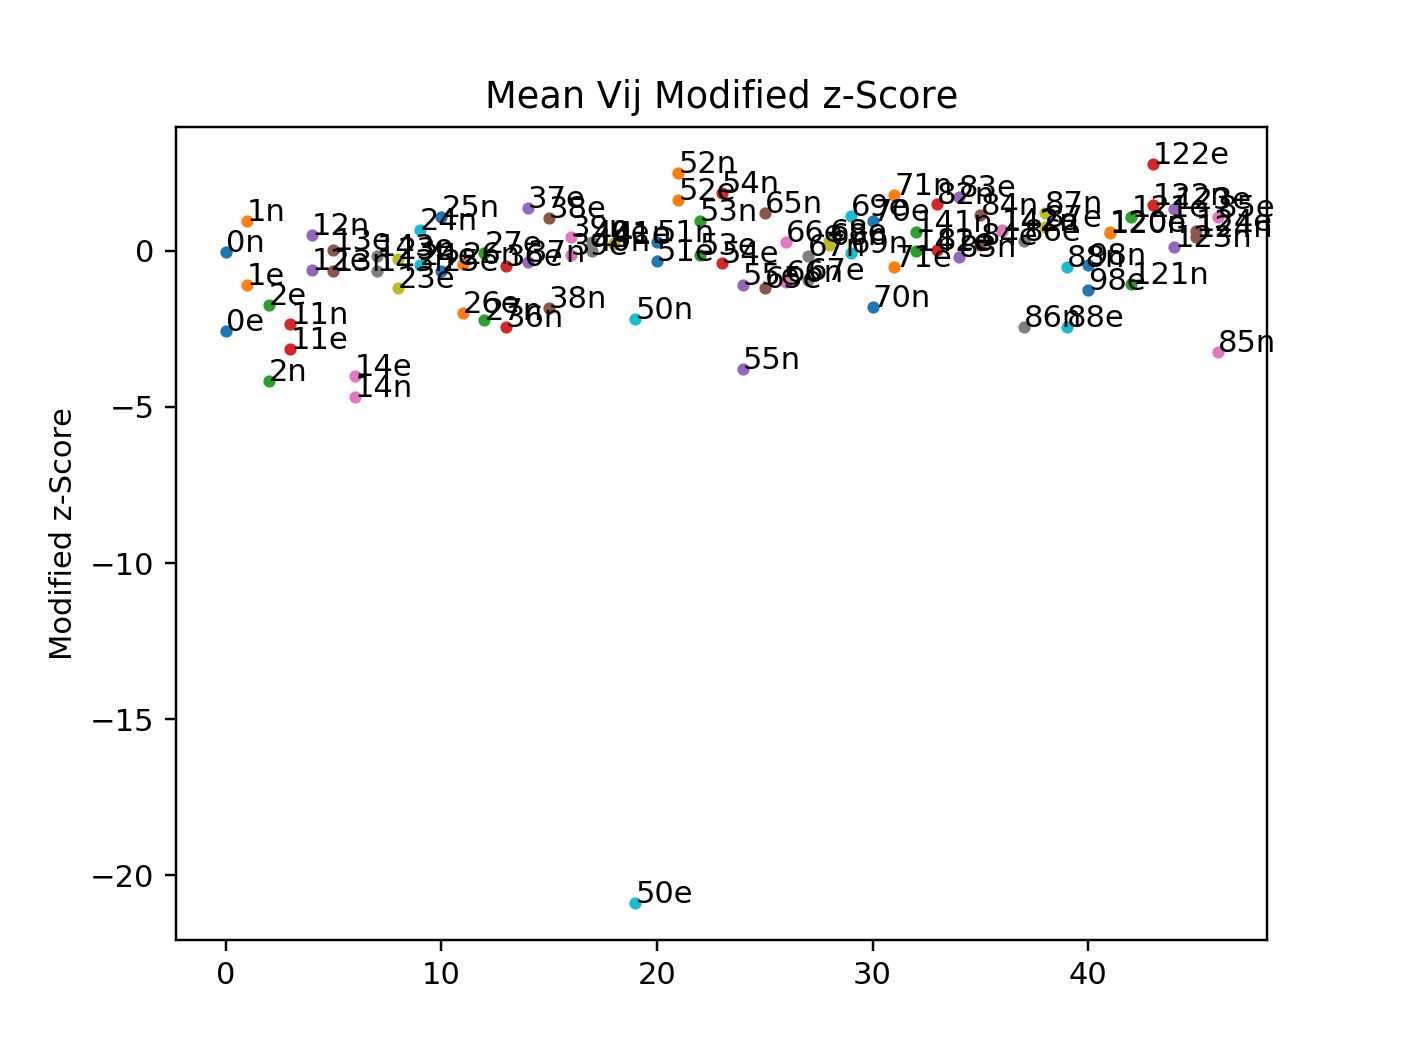

<IPython.core.display.Javascript object>


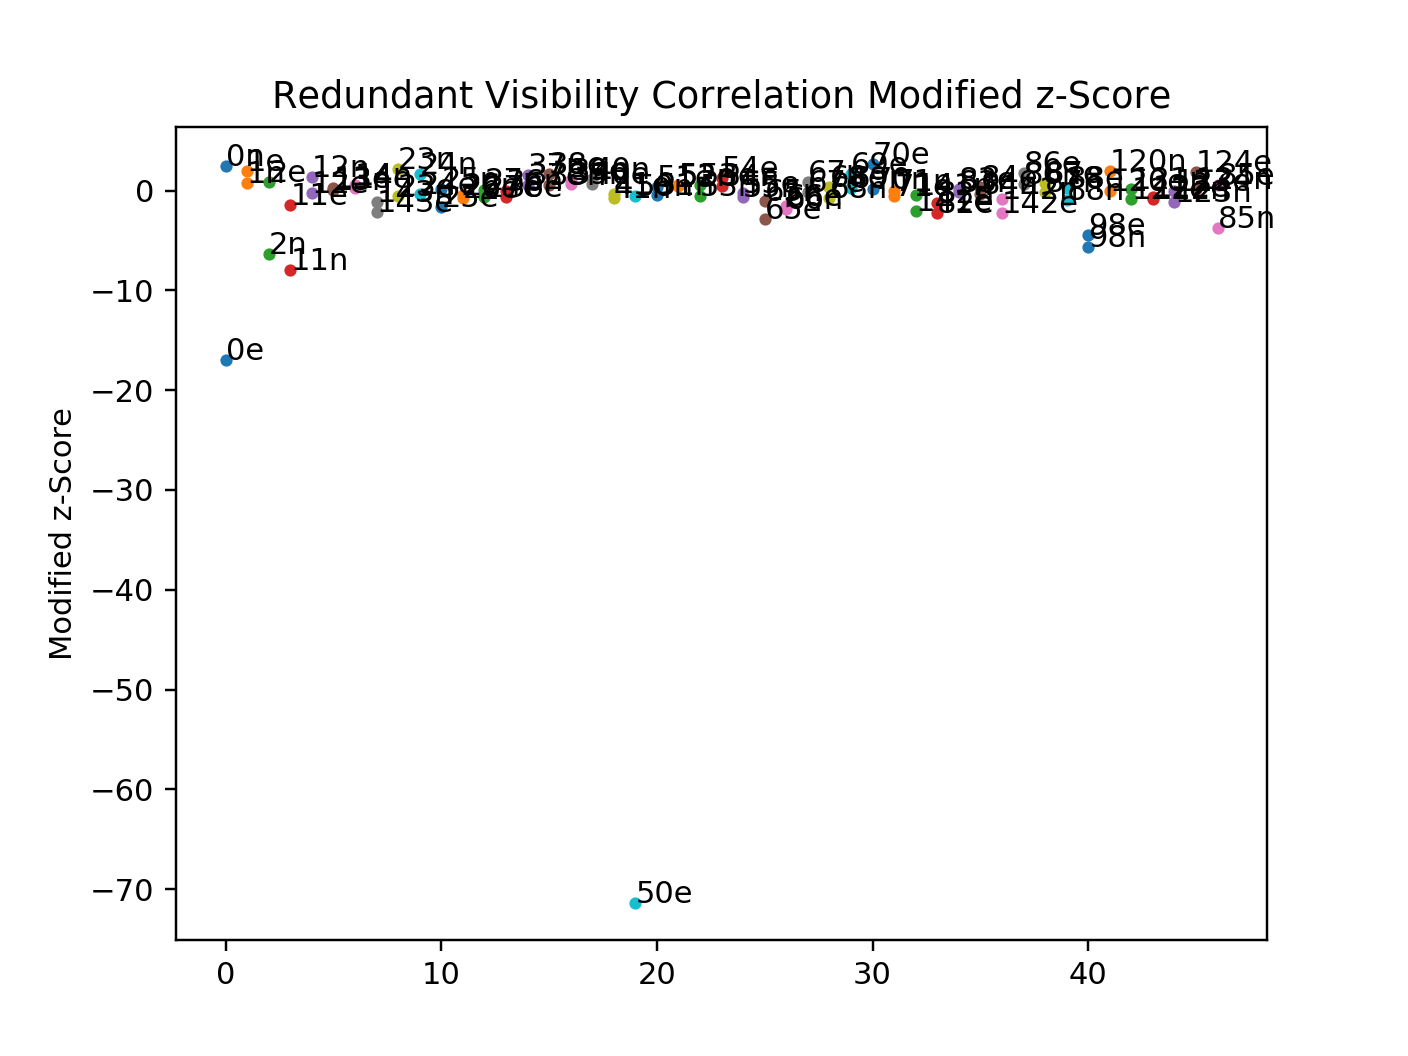

<IPython.core.display.Javascript object>


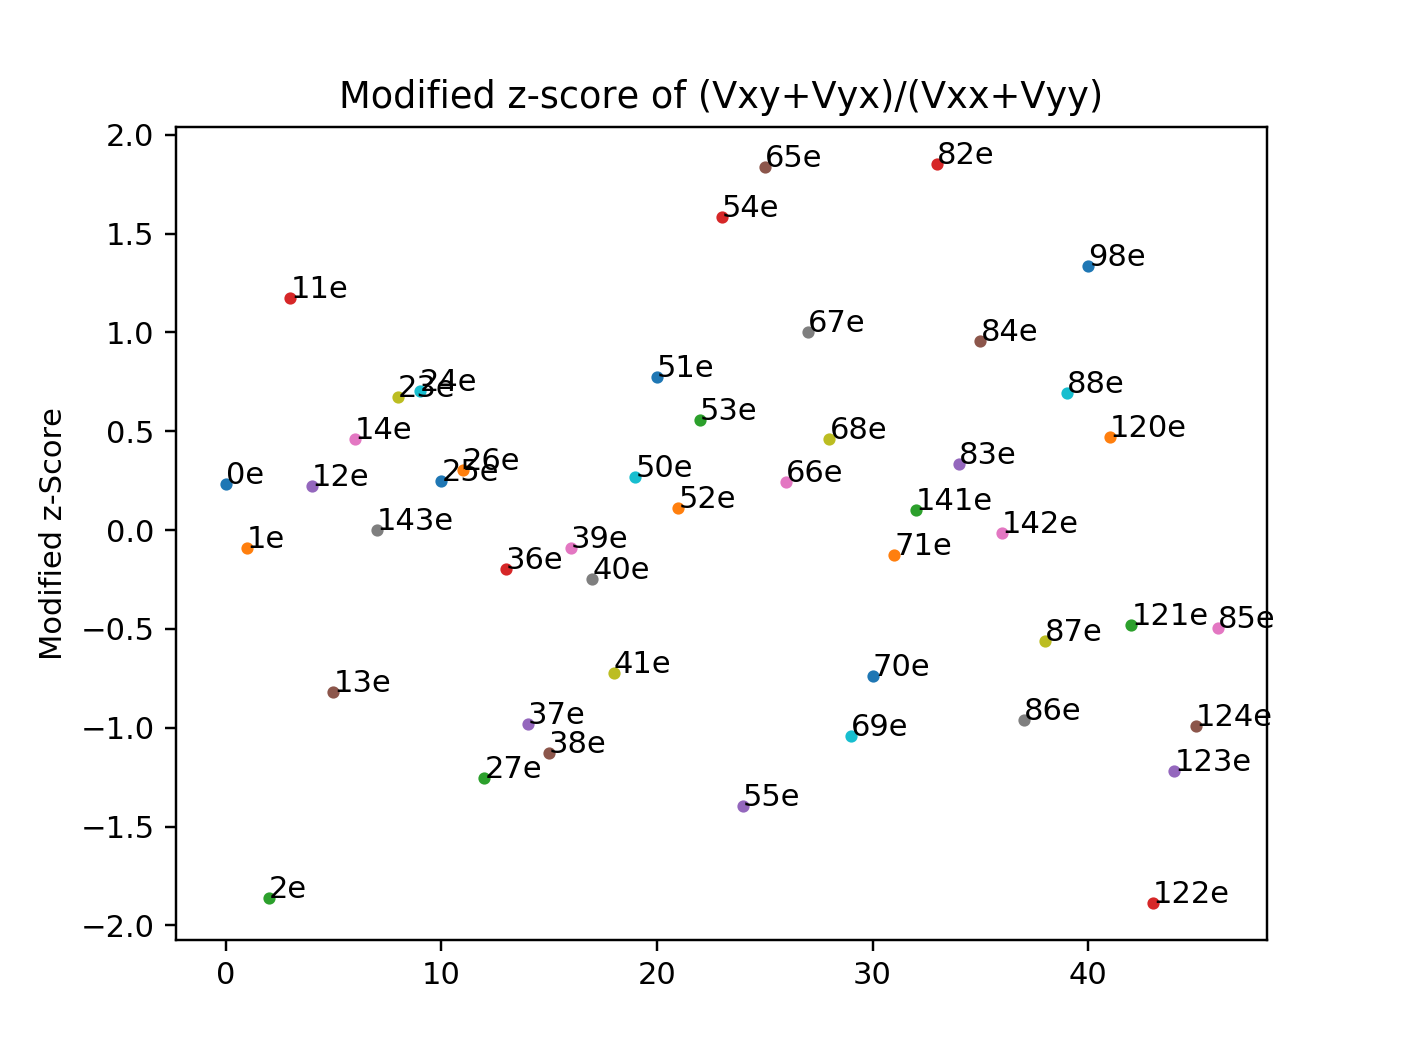

<IPython.core.display.Javascript object>


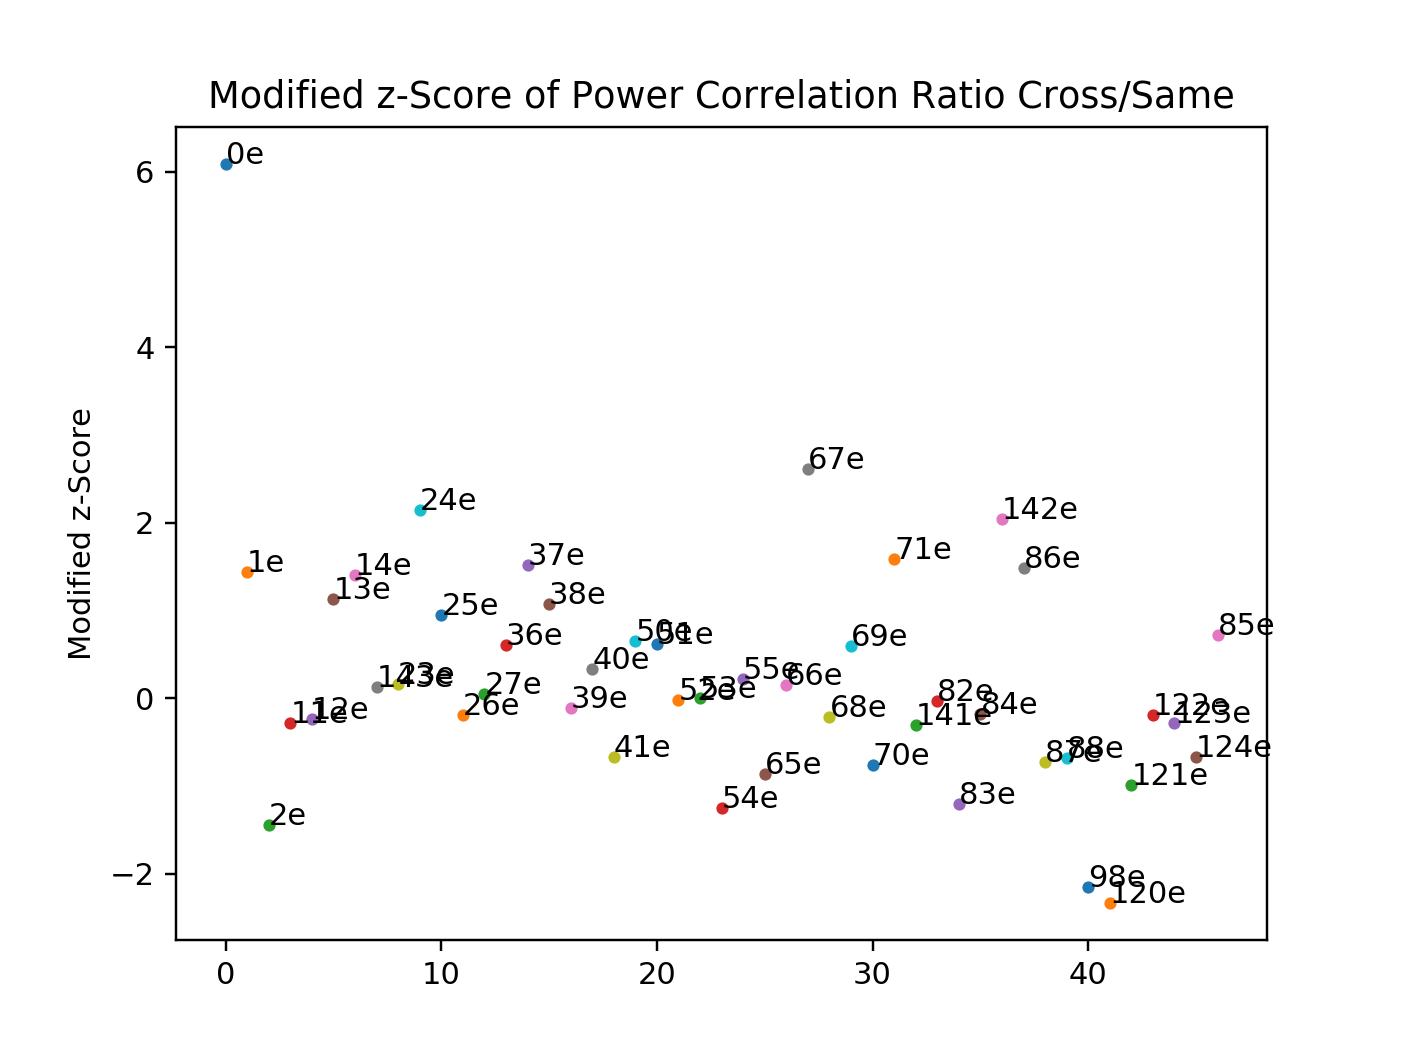

In [11]:
print "Ant Metrics for {}".format(antfile)
plt.figure()
plot_metric(ant_metrics['final_mod_z_scores']['meanVij'], 
            title = 'Mean Vij Modified z-Score')

plt.figure()
plot_metric(ant_metrics['final_mod_z_scores']['redCorr'],
            title = 'Redundant Visibility Correlation Modified z-Score')

plt.figure()
plot_metric(ant_metrics['final_mod_z_scores']['meanVijXPol'], antpols=['x'],
            title = 'Modified z-score of (Vxy+Vyx)/(Vxx+Vyy)')

plt.figure()
plot_metric(ant_metrics['final_mod_z_scores']['redCorrXPol'], antpols=['x'],
            title = 'Modified z-Score of Power Correlation Ratio Cross/Same')

### Ant Metrics `xants` over the entire observation

In [13]:
# append xants ant metrics over night
xants = np.zeros((Nants*2, Nfiles))
dead_ants = np.zeros((Nants*2, Nfiles))
cross_ants = np.zeros((Nants*2, Nfiles))
badants = []
pol2ind = {'x':0, 'y':1}

for i, fbase in enumerate(xxfile_bases):
    antfname = fbase.split('.')
    antfname.pop(3)
    antfname = os.path.join(data_path, '.'.join(antfname) + '.ant_metrics.hdf5')
    try:
        antmets = hqm.ant_metrics.load_antenna_metrics(antfname)
        for j in antmets['xants']:
            xants[2*ants.index(j[0])+pol2ind[j[1]], i] = 1
        badants.extend(map(lambda x: x[0], antmets['xants']))
        for j in antmets['crossed_ants']:
            cross_ants[2*ants.index(j[0])+pol2ind[j[1]], i] = 1
        for j in antmets['dead_ants']:
            dead_ants[2*ants.index(j[0])+pol2ind[j[1]], i] = 1
    except:
        pass
    
badants = np.unique(badants)

xants[np.where(xants==1.0)] *= np.nan
dead_ants[np.where(dead_ants==0.0)] *= np.nan
cross_ants[np.where(cross_ants==0.0)] *= np.nan

<IPython.core.display.Javascript object>


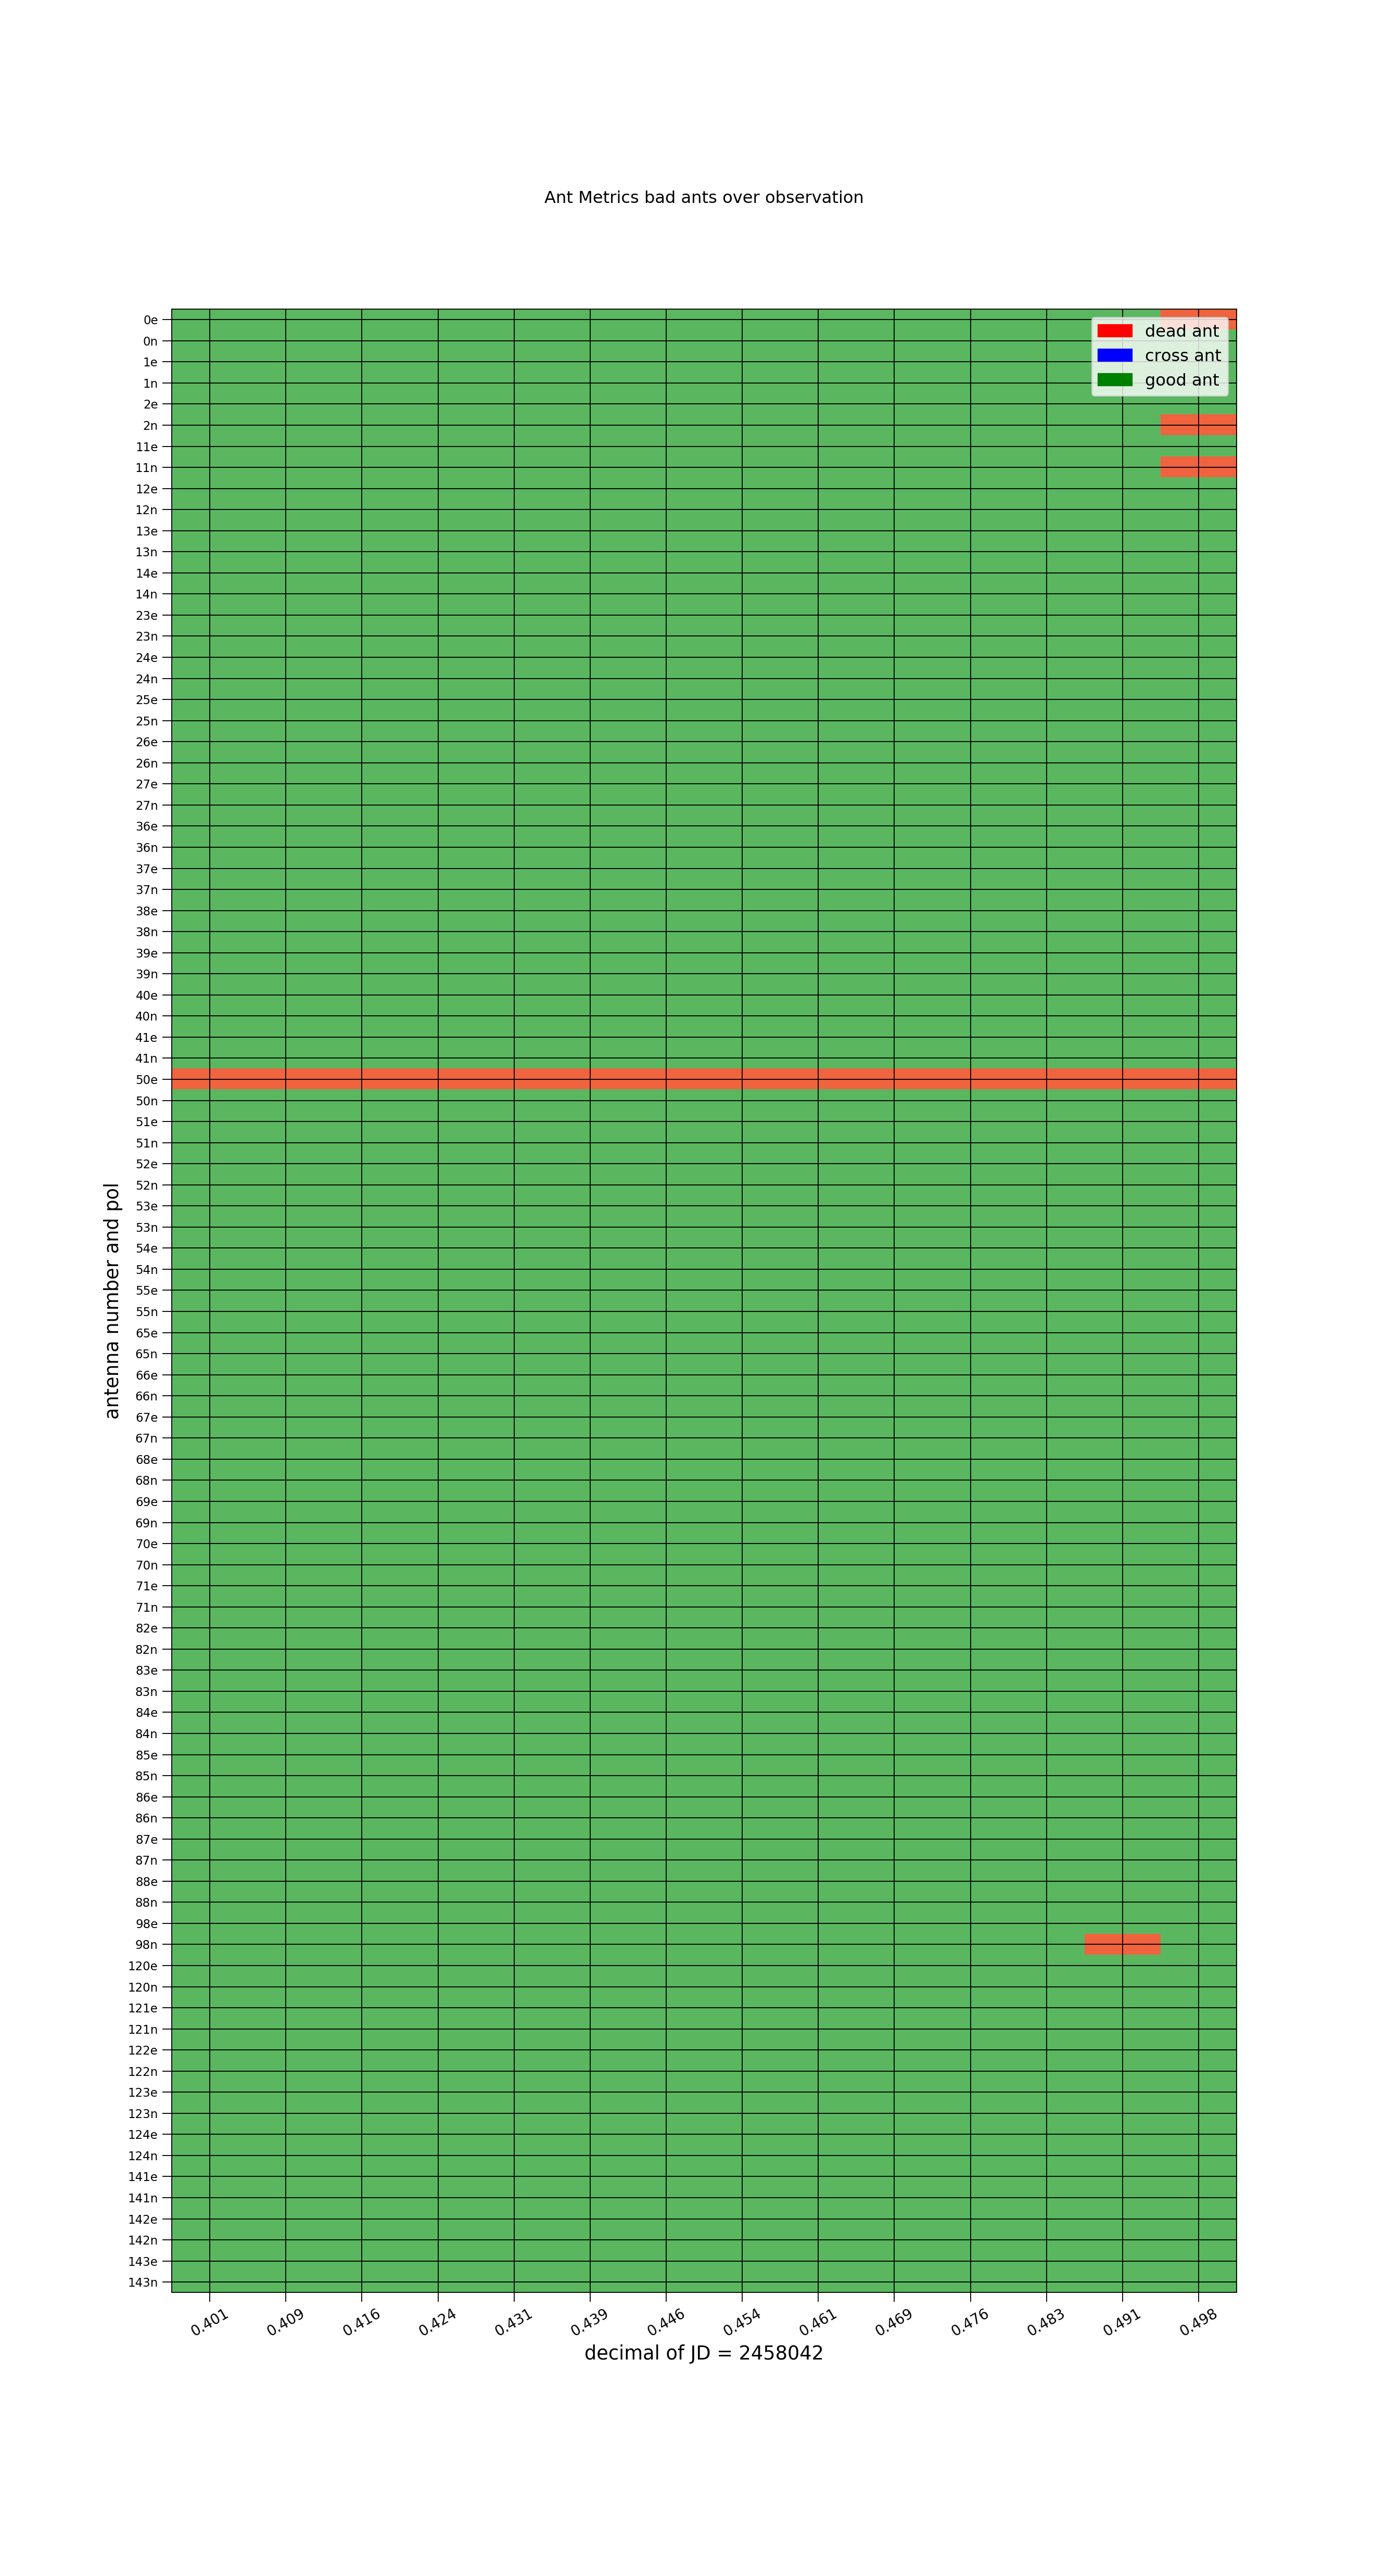

In [16]:
# figure
fig, ax = plt.subplots(1, figsize=(16,30), dpi=75)

# plotting
# plot xants
ax.matshow(xants, aspect='auto', cmap='RdYlGn_r', vmin=-.3, vmax=1.3,
           extent=[0, len(xxfile_times), Nants*2, 0])

# only plot if not completely masked
if np.isnan(dead_ants).min() == False:
    ax.matshow(dead_ants, aspect='auto', cmap='RdYlGn_r', vmin=-.3, vmax=1.3,
               extent=[0, len(xxfile_times), Nants*2, 0])
    
if np.isnan(cross_ants).min() == False:
    ax.matshow(cross_ants, aspect='auto', cmap='RdBu', vmin=-.3, vmax=1.3,
               extent=[0, len(xxfile_times), Nants*2, 0])

# axes
ax.grid(color='k')
ax.xaxis.set_ticks_position('bottom')
ax.set_xticks(np.arange(len(xxfile_times))+0.5)
ax.set_yticks(np.arange(Nants*2)+0.5)
ax.tick_params(size=8)
if Nfiles > 20:
    ticklabels = np.around(xxfile_times % jd_start, 3).astype(str)
    ticklabels[::2] = ''
    ax.set_xticklabels(ticklabels)
else:
    ax.set_xticklabels(np.around(xxfile_times % jd_start, 3))
ax.set_yticklabels([''.join([str(a), p]) for a in ants for p in ['e', 'n']])

[t.set_rotation(30) for t in ax.get_xticklabels()]
[t.set_size(12) for t in ax.get_xticklabels()]
[t.set_rotation(0) for t in ax.get_yticklabels()]
[t.set_size(10) for t in ax.get_yticklabels()]

ax.set_title("Ant Metrics bad ants over observation", fontsize=14)
ax.set_xlabel('decimal of JD = {}'.format(int(jd_start)), fontsize=16)
ax.set_ylabel('antenna number and pol', fontsize=16)
red_ptch = mpatches.Patch(color='red')
grn_ptch = mpatches.Patch(color='green')
blu_ptch = mpatches.Patch(color='blue')
ax.legend([red_ptch, blu_ptch, grn_ptch], ['dead ant', 'cross ant', 'good ant'], fontsize=14)

### Plot Ant Metrics over observation for specific antennas

In [45]:
# get ant metrics over night for specific antennas
ant_indices = np.where(np.sum(np.isnan(xants), axis=1) > 0)[0]

# append ant metrics over night
antpols = np.concatenate(map(lambda x: [str(x)+'e', str(x)+'n'], ants))[ant_indices]
ap_list = OrderedDict([(ap, []) for ap in antpols])
mets = {'meanVij':copy.deepcopy(ap_list), 'meanVijXPol':copy.deepcopy(ap_list), 'redCorr':copy.deepcopy(ap_list), 'redCorrXPol':copy.deepcopy(ap_list)}
tfiles = []
pol2ind = {'x':0, 'y':1}

for i, fbase in enumerate(xxfile_bases):
    antfname = fbase.split('.')
    antfname.pop(3)
    antfname = os.path.join(data_path, '.'.join(antfname) + '.ant_metrics.hdf5')
    try:
        antmets = hqm.ant_metrics.load_antenna_metrics(antfname)['final_mod_z_scores']
        tfiles.append(float('.'.join(fbase.split('.')[1:3])))
        for am in antmets.keys():
            for ap in antpols:
                a,p = re.match(r"([0-9]+)([a-z]+)", ap, re.I).groups()
                mets[am][ap].append(antmets[am][(int(a), 'x' if p == 'e' else 'y')])
    except:
        pass
    
tfiles = np.array(tfiles) % np.floor(np.min(tfiles))

<IPython.core.display.Javascript object>


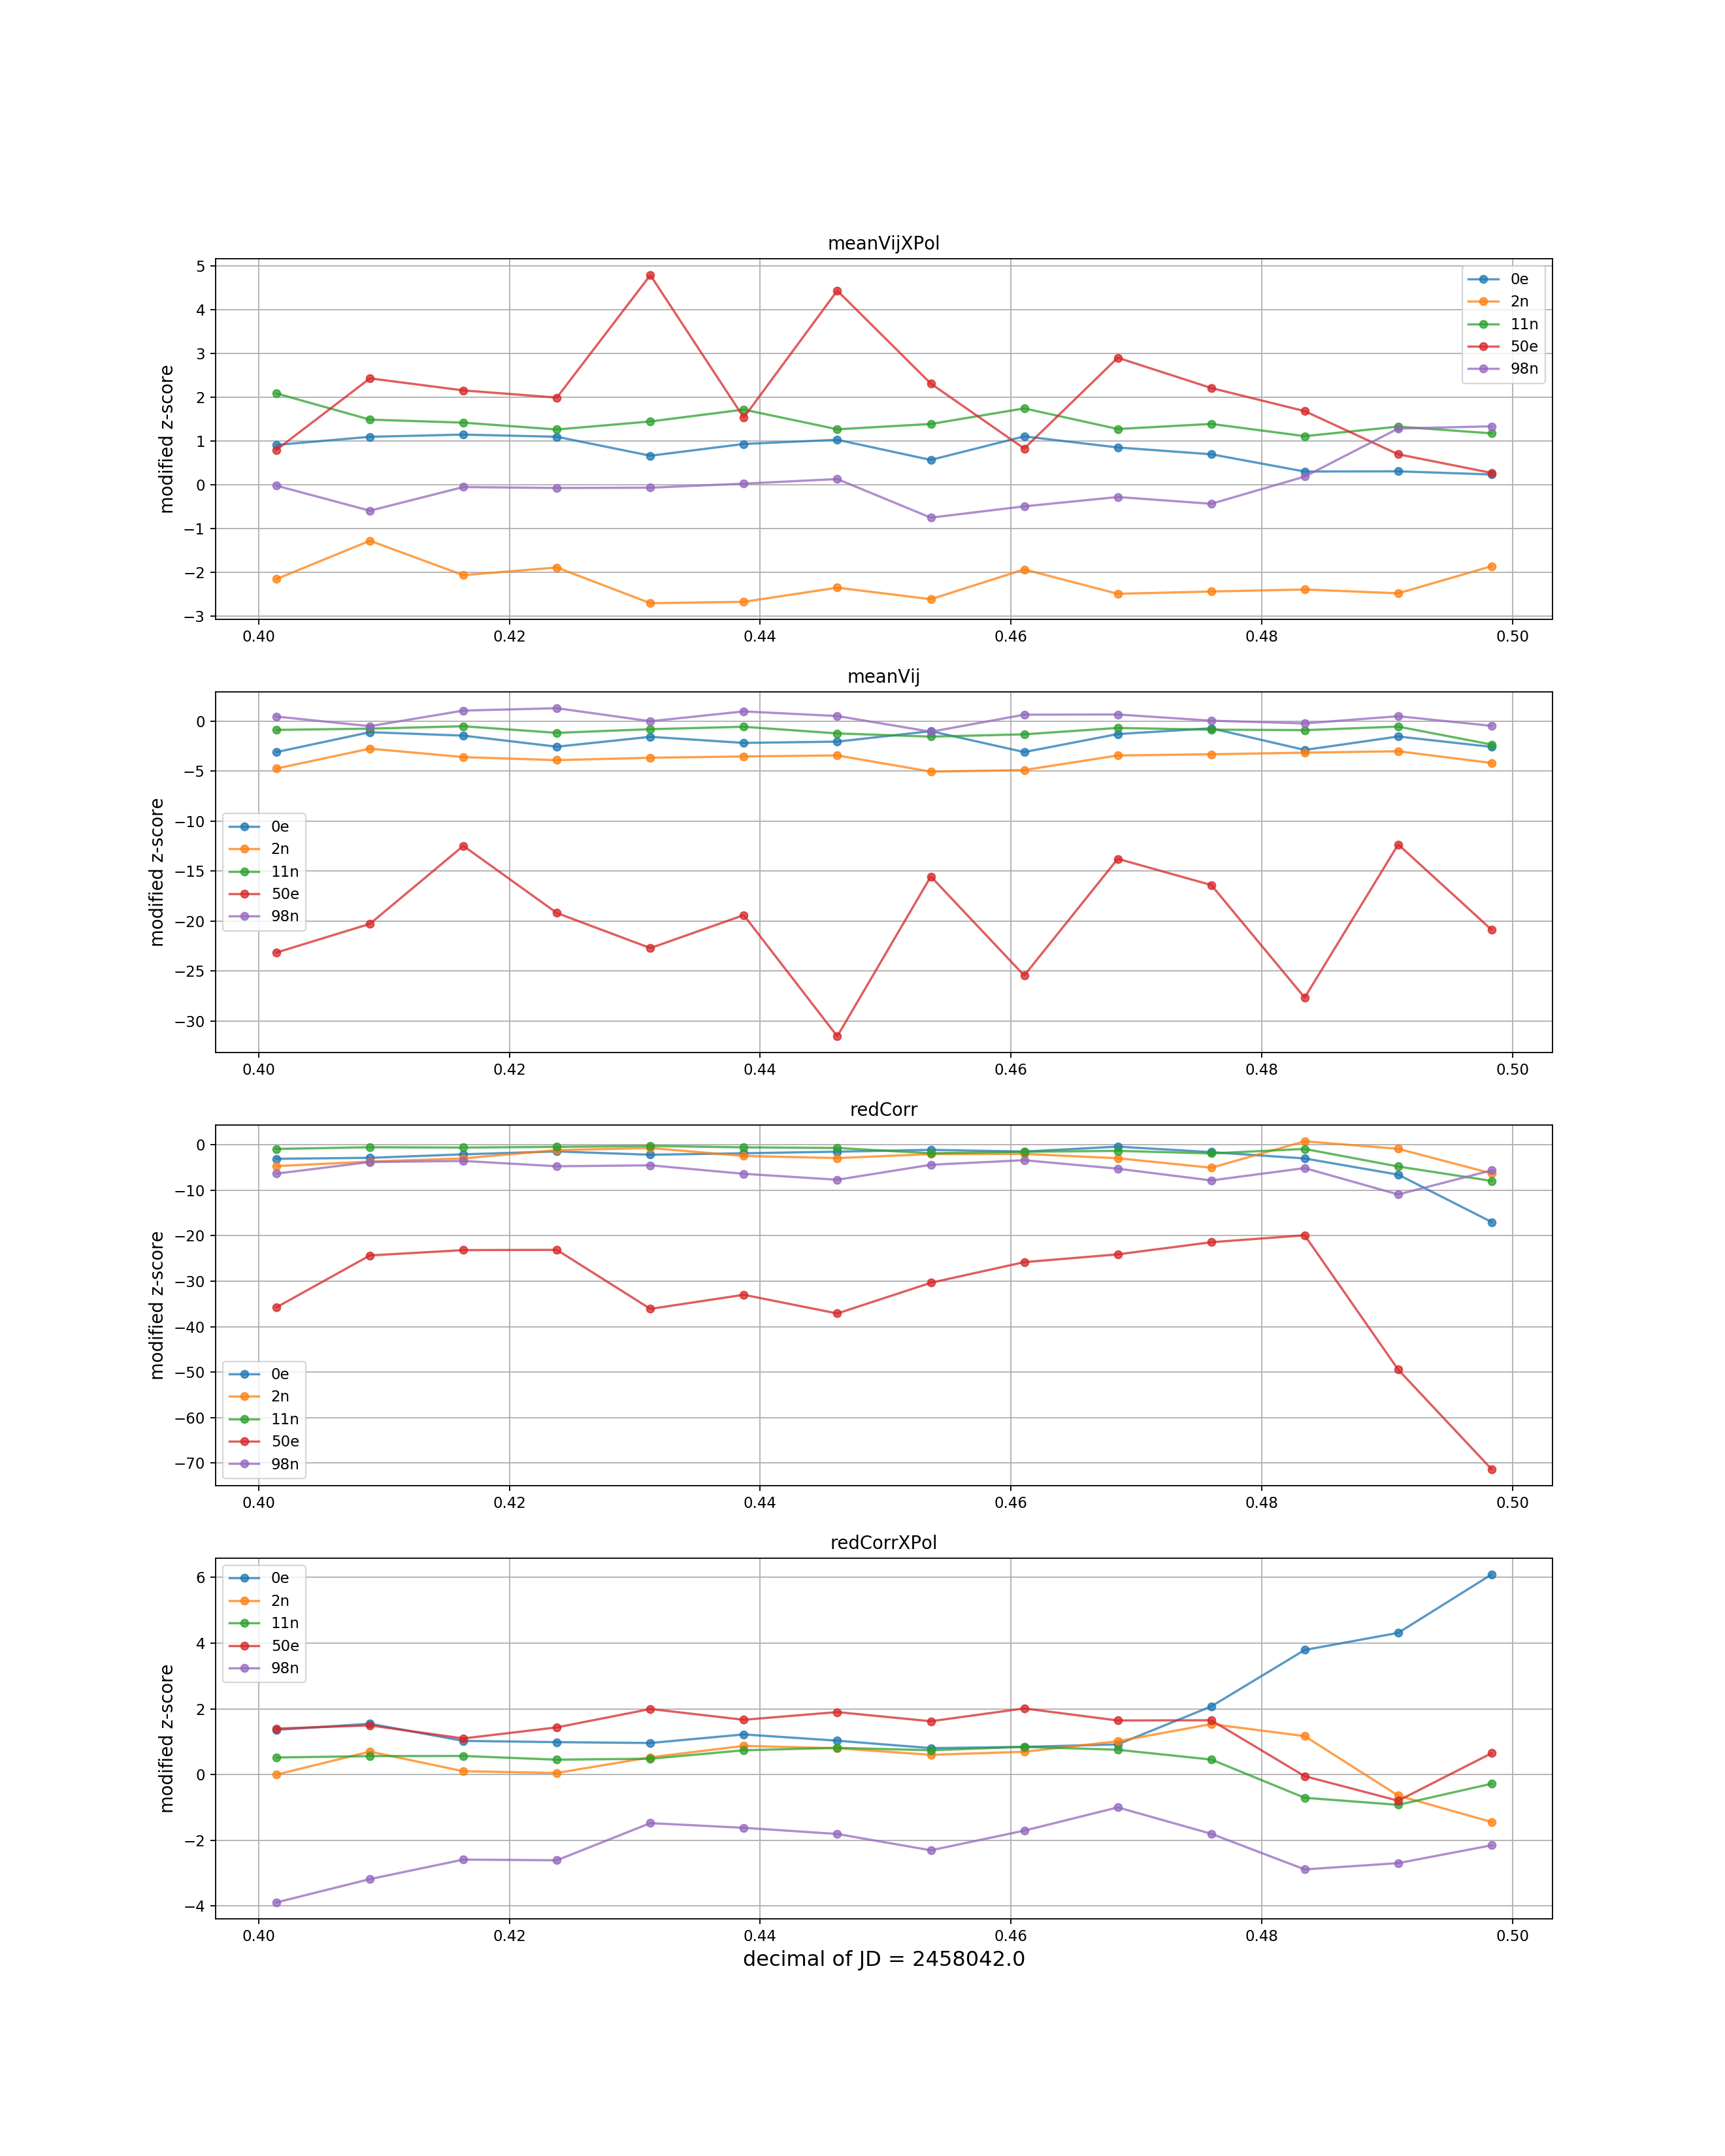

Text(0.5,0,'decimal of JD = 2458042.0')

In [46]:
fig, ax = plt.subplots(4, 1, figsize=(16,20), dpi=75)

for i, am in enumerate(mets.keys()):
    ax[i].grid(True)
    pl = np.concatenate([ax[i].plot(tfiles, mets[am][k], alpha=0.75, ms=5, marker='o') for k in mets[am].keys()])
    ax[i].legend(pl, mets[am].keys())
    ax[i].set_title(am)
    ax[i].set_ylabel('modified z-score', fontsize=12)

ax[-1].set_xlabel('decimal of JD = {}'.format(jd_start), fontsize=14)